In [2]:
import os
os.chdir(r'C:\Users\davme\Documents\Università Bocconi\DSBA\Curricular Courses 20222023\STATISTICS AND PROBABILITY\Computational Statistics Module\Final Project\Final Project\Assignment Content')

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Definition of the function
This function produces an num_samples × m matrix THETA, containing a value of the within-school mean for each school at each iteration of the Markov. Additionally, the matrix SMT stores values of sigma^2, mu and tau^2, representing approximate, correlated draws from the posterior distribution of these parameters.

In [281]:
def gibbs8(y, nu0, sigma20, eta0, tau20, mu0, gamma20, num_samples):
    
    # starting values
    m = len(np.unique(y[:, 0]))   # we generate a vector that contains the code of the schools (index i ---> school i+1)
    n = np.empty(m, dtype=float)   # initialization of the vector containing the number of observations per group
    ybar = np.empty(m, dtype=float)   # initialization of the vector containing the mean of each group
    sv = np.empty(m, dtype=float)   # initialization of the vector containing the variance for each group
    for j in range(m):   # in this loop we fill the vectors initializated above
        ybar[j] = np.mean(y[y[:, 0] == j+1, 1])
        sv[j] = np.var(y[y[:, 0] == j+1, 1])
        n[j] = sum(y[:, 0] == j+1)

    theta = np.copy(ybar)   # this vector will contain the updated values of theta
    sigma2 = np.mean(sv)   # this vector will contain the updated values of sigma^2
    mu = np.mean(theta)   # this vector will contain the updated values of mu
    tau2 = np.var(theta)   # this vector will contain the updated values of tau^2
    
    # setup MCMC
    np.random.seed(415)
    THETA = np.empty((num_samples, m), dtype=float)   # matrix to store samples of theta
    SMT = np.empty((num_samples, 3), dtype=float)   # matrix to store samples of (sigma2, mu, tau2)

    # MCMC algorithm
    for s in range(num_samples):   # performs Gibbs sampling for num_samples iterations
        
        # sample new values of the thetas
        for j in range(m):
            v_theta = 1 / (n[j] / sigma2 + 1 / tau2)
            e_theta = v_theta * (ybar[j] * n[j] / sigma2 + mu / tau2)
            theta[j] = np.random.normal(e_theta, np.sqrt(v_theta))

        # sample new values of sigma^2
        nun = nu0 + sum(n)   # update the degrees of freedom for the inverse-gamma distribution of sigma^2
        ss = nu0 * sigma20
        for j in range(m):
            ss += sum((y[y[:, 0] == j+1, 1] - theta[j]) ** 2)
        sigma2 = 1 / np.random.gamma(nun / 2, 2 / ss)

        # sample new values of mu
        v_mu = 1 / (m / tau2 + 1 / gamma20)
        e_mu = v_mu * (m * np.mean(theta) / tau2 + mu0 / gamma20)
        mu = np.random.normal(e_mu, np.sqrt(v_mu))

        # sample new values of tau^2
        etam = eta0 + m   # update the degrees of freedom for the inverse-gamma distribution of tau^2
        ss = eta0 * tau20 + sum((theta - mu) ** 2)
        tau2 = 1 / np.random.gamma(etam / 2, 2 / ss)

        # storing the results
        THETA[s, :] = theta
        SMT[s, :] = (sigma2, mu, tau2)
    
    return THETA, SMT

## Loading the data

In [282]:
y = pd.read_csv('Scores_without_covariates.csv', delimiter = ' ')
y = y.to_numpy()
y

array([[  1.  ,  52.11],
       [  1.  ,  57.65],
       [  1.  ,  66.44],
       ...,
       [100.  ,  47.66],
       [100.  ,  55.43],
       [100.  ,  29.73]])

## Choice of the prior parameters and execution of the model

In [297]:
# choice of the parameters
nu0 = 1         # prior for p(sigma2)
sigma20 = 100   # prior for p(sigma2)
eta0 = 1        # prior for p(tau2)
tau20 = 100     # prior for p(tau2)
mu0 = 50        # prior for p(mu)
gamma20 = 25    # prior for p(mu)

num_samples = 5000   # modify if you want a different number of iterations

THETA, SMT = gibbs8(y, nu0, sigma20, eta0, tau20, mu0, gamma20, num_samples)

print('THETA')
print(THETA)

print()
print('SMT')
print(SMT)

THETA
[[48.12984305 46.46920891 45.54521814 ... 52.89820012 52.51574752
  49.48315439]
 [52.89844715 45.88317675 53.05628366 ... 51.94657471 52.05896202
  48.1170103 ]
 [50.46893583 49.6134043  48.86806861 ... 52.62772795 53.76774032
  48.13895034]
 ...
 [49.3845586  48.61885014 49.22212668 ... 50.56038217 52.01639668
  49.94101328]
 [51.48342435 49.21030055 46.02941552 ... 52.57513091 50.08657914
  47.36908742]
 [50.52462055 46.63934605 49.14272583 ... 51.71165612 47.75437571
  47.8989908 ]]

SMT
[[83.90564705 47.89805906 31.79489994]
 [82.5856256  49.34365145 31.30722069]
 [82.27198908 47.87392315 28.14926179]
 ...
 [88.3249047  48.01274563 17.07079688]
 [87.21160676 47.8370616  23.98165725]
 [86.21086433 47.32553608 26.051019  ]]


## Diagnostics (before making inference)

### Box- plots

We set the data for the box-plots.

In [298]:
data = pd.DataFrame(SMT[:], columns = ['S', 'M', 'T'])
data.reset_index(inplace=True)   # we transfrom the index in a command in order to use it to divide the observations
data

,index,S,M,T
0,0,83.905647,47.898059,31.794900
1,1,82.585626,49.343651,31.307221
2,2,82.271989,47.873923,28.149262
3,3,84.203911,48.016312,27.230992
4,4,82.800805,47.556143,26.829356
...,...,...,...,...
4995,4995,92.395977,47.576200,25.113226
4996,4996,89.214308,47.286416,17.374576
4997,4997,88.324905,48.012746,17.070797
4998,4998,87.211607,47.837062,23.981657


#### Box-plot for $\sigma^2 $

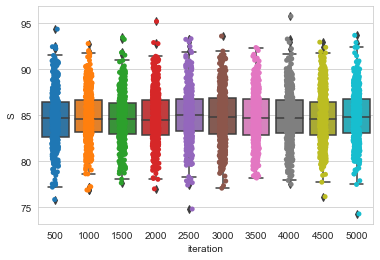

In [299]:
# S

#make a box plot by grouping together the first 500 obs, the second 500,...
data["iteration"] = (data['index'] // 500 + 1) * 500   # we divide the records in groups of 500
sns.set_style('whitegrid')   # setting the style
ax = sns.boxplot(x="iteration",y="S",data=data)   # representation of the box-plots
ax = sns.stripplot(x="iteration", y="S",data=data)   # representation of the observations

#### Box-plot for $ \mu $

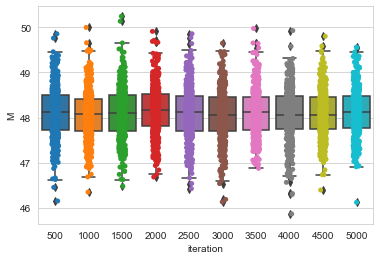

In [300]:
# M

#make a box plot by grouping together the first 500 obs, the second 500,...
data["iteration"] = (data['index'] // 500 + 1) * 500   # we divide the records in groups of 500
sns.set_style('whitegrid')   # setting the style
ax = sns.boxplot(x="iteration",y="M",data=data)   # representation of the box-plots
ax = sns.stripplot(x="iteration", y="M",data=data)   # representation of the observations

#### Box-plot for $ \tau^2 $

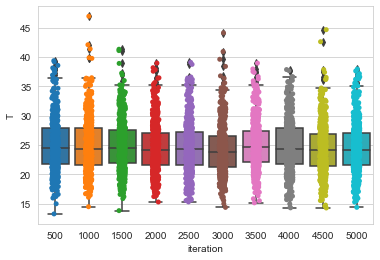

In [301]:
# T

#make a box plot by grouping together the first 500 obs, the second 500,...
data["iteration"] = (data['index'] // 500 + 1) * 500   # we divide the records in groups of 500
sns.set_style('whitegrid')   # setting the style
ax = sns.boxplot(x="iteration",y="T",data=data)   # representation of the box-plots
ax = sns.stripplot(x="iteration", y="T",data=data)   # representation of the observations

#### Box-plot for $ \theta_{j} $

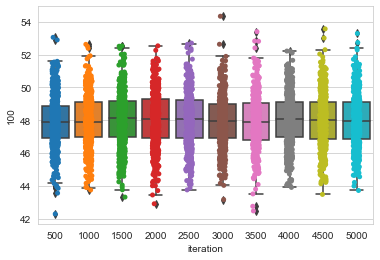

In [302]:
# theta
data = pd.DataFrame(THETA[:], columns = [i for i in range(1,len(THETA[0])+1)])
data.reset_index(inplace=True)   # we transfrom the index in a command in order to use it to divide the observations

#make a box plot by grouping together the first 500 obs, the second 500,...
data["iteration"] = (data['index'] // 500 + 1) * 500   # we divide the records in groups of 500
sns.set_style('whitegrid')   # setting the style
ax = sns.boxplot(x="iteration",y=100,data=data)   # change the number in y in order to have the box-plot of another school (1-100)
ax = sns.stripplot(x="iteration", y=100,data=data)

### Trace plots

#### Trace plot for $ \sigma^2 $

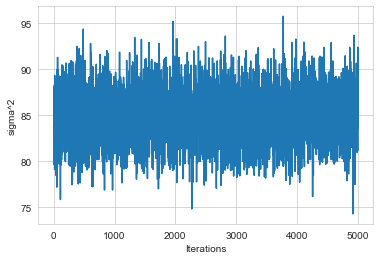

In [303]:
plt.plot(SMT[:, 0])
plt.xlabel("Iterations")
plt.ylabel("sigma^2")
plt.show()

#### Trace plot for $ \mu $

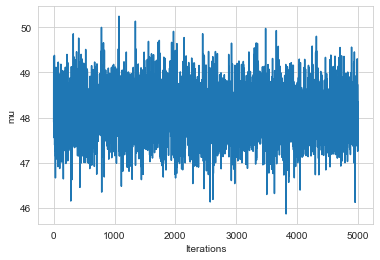

In [304]:
plt.plot(SMT[:, 1])
plt.xlabel("Iterations")
plt.ylabel("mu")
plt.show()

#### Trace plot for $ \tau^2 $

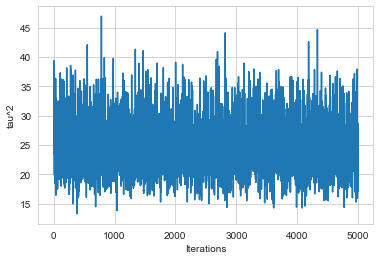

In [305]:
plt.plot(SMT[:, 2])
plt.xlabel("Iterations")
plt.ylabel("tau^2")
plt.show()

#### Trace plot for $ \theta_{j} $

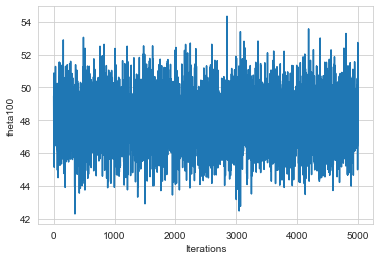

In [306]:
j = 100   # change the number and insert the code of the school we want to print the trend plot of the parameter of

plt.plot(THETA[:, j-1])
plt.xlabel("Iterations")
plt.ylabel(f"theta{j}")
plt.show()

### Autocorrelation function and MC standard errors

#### Autocorrelation function and MC standard error for $ \sigma^2 $

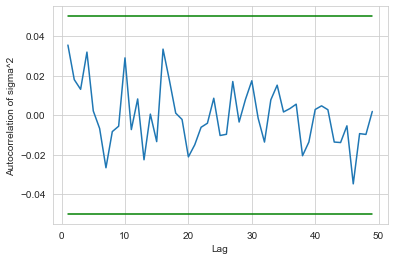


Lag-1 autocorrelations for the sequence sigma^2:  0.03541225546572253

Effective sample size for sigma^2:  4669
Approximate MC standard error for sigma^2:  0.04047215396343615


In [307]:
samples = SMT[:,0]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of sigma^2')
plt.show()

print()
print('Lag-1 autocorrelations for the sequence sigma^2: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print('Effective sample size for sigma^2: ', ess)
print('Approximate MC standard error for sigma^2: ', mc_std_dev)

#### Autocorrelation function and MC standard error for $ \mu $

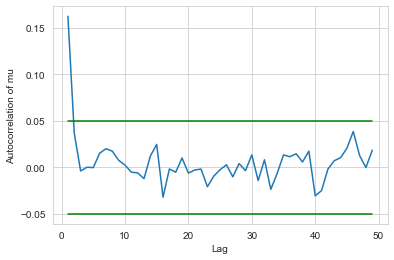


Lag-1 autocorrelations for the sequence mu:  0.16262638570309743

Effective sample size for mu:  3772
Approximate MC standard error for mu:  0.008871110628942278


In [308]:
samples = SMT[:,1]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of mu')
plt.show()

print()
print('Lag-1 autocorrelations for the sequence mu: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print('Effective sample size for mu: ', ess)
print('Approximate MC standard error for mu: ', mc_std_dev)

#### Autocorrelation function and MC standard error for $ \tau^2 $

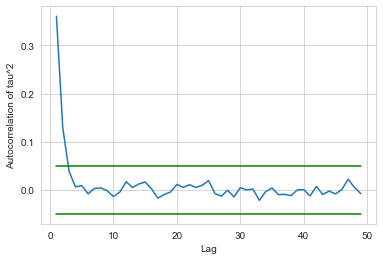


Lag-1 autocorrelations for the sequence tau^2:  0.3604947289380724

Effective sample size for tau^2:  2905
Approximate MC standard error for tau^2:  0.08085955705077286


In [309]:
samples = SMT[:,2]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of tau^2')
plt.show()

print()
print('Lag-1 autocorrelations for the sequence tau^2: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print('Effective sample size for tau^2: ', ess)
print('Approximate MC standard error for tau^2: ', mc_std_dev)

#### Autocorrelation function and MC standard error for $ \theta_{j} $

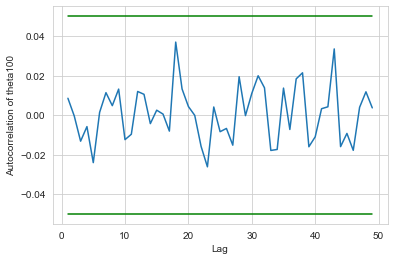


Lag-1 autocorrelations for the sequence theta100:  0.008507551298166079

Effective sample size for theta100:  4916
Approximate MC standard error for theta100:  0.02301138902945158


In [310]:
j = 100   # change if you another parameter thetaj

samples = THETA[:,j-1]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel(f'Autocorrelation of theta{j}')
plt.show()

print()
print(f'Lag-1 autocorrelations for the sequence theta{j}: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print(f'Effective sample size for theta{j}: ', ess)
print(f'Approximate MC standard error for theta{j}: ', mc_std_dev)

## Relationship between $ \bar{y} $ and $ \hat{\theta} = E[\theta_{j}|y_{1},...,y_{m}] $

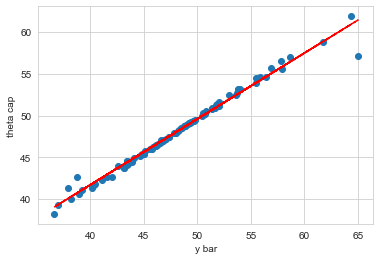

In [246]:
theta_cap = np.mean(THETA, axis = 0)

m = len(np.unique(y[:, 0]))
y_bar = np.empty(m, dtype=float)
for j in range(m):
    y_bar[j] = np.mean(y[y[:, 0] == j+1, 1])
    
z = np.polyfit(y_bar, theta_cap, 1)
p = np.poly1d(z)
    
plt.plot(y_bar, theta_cap, 'o')
plt.plot(y_bar, p(y_bar), 'r--')
plt.xlabel("y bar")
plt.ylabel("theta cap")
plt.show()

## Shrinkage as a function of the group-specific sample size

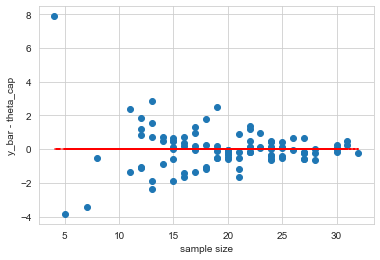

In [247]:
theta_cap = np.mean(THETA, axis = 0)

m = len(np.unique(y[:, 0]))
y_bar = np.empty(m, dtype=float)
for j in range(m):
    y_bar[j] = np.mean(y[y[:, 0] == j+1, 1])
    
z = np.polyfit(n, y_bar-theta_cap, 1)
p = np.poly1d(z)

plt.plot(n, y_bar - theta_cap, 'o')
plt.plot(n, [0]*n, 'r--')
plt.xlabel("sample size")
plt.ylabel("y_bar - theta_cap")
plt.show()

## Estimation of the parameters

In [248]:
theta_est = np.mean(THETA, axis = 0)

print("Estimates of the theta:", theta_est)
print()
j = 15   # change with the index of the school you want the estimate of theta
print("Estimate of theta for the school: ", theta_est[j-1])
print()
print(f"The school with maximum theta is {np.argmax(theta_est)+1} and the corresponding value is {theta_est[np.argmax(theta_est)]}")
print(f"The school with minimum theta is {np.argmin(theta_est)+1} and the corresponding value is {theta_est[np.argmin(theta_est)]}")

Estimates of the theta: [50.54873491 46.68002229 48.69509257 47.4259303  38.22921412 40.64646446
 41.82985965 48.71933019 49.02614943 42.27049831 55.55056064 50.28658347
 49.26098997 56.94730478 54.58095131 54.51692407 41.35314764 49.99394126
 44.54917602 46.17626124 50.20358036 47.92641675 51.2519512  45.99885884
 45.36163313 46.77897207 44.51914069 51.3018625  46.49105287 49.384297
 49.07954238 50.05349945 47.44915522 46.02661622 54.5756055  52.3983828
 46.30705506 51.2260936  46.45963547 48.90228887 55.72565329 46.38153662
 50.76191536 49.07901421 45.71811774 41.34652533 44.51627844 46.97654569
 40.04293505 42.61380784 61.87886293 49.25120466 43.90994501 46.539857
 43.74200905 49.10042336 44.47164446 48.46757441 49.50554146 42.68719064
 45.45316885 50.87333075 49.3169976  43.75370067 47.93639412 48.22591452
 57.13813369 45.30331389 51.38071958 44.03968174 46.8981303  39.33010752
 53.18329522 41.65974903 48.7084223  53.94421709 45.17951548 41.14043595
 58.83136088 51.17243741 47.0764

In [249]:
print("Estimate of (sigma2, mu, tau2):", np.mean(SMT[:,0], axis = 0), np.mean(SMT[:,1], axis = 0), np.mean(SMT[:,2], axis = 0))
print()
print("Estimate of (sigma, mu, tau):", np.mean(np.sqrt(SMT[:,0]), axis = 0), np.mean(SMT[:,1], axis = 0), np.mean(np.sqrt(SMT[:,2]), axis = 0))

Estimate of (sigma2, mu, tau2): 84.81311677727987 48.1358495958867 24.73463722535237

Estimate of (sigma, mu, tau): 9.208170903820838 48.1358495958867 4.955004614385674


## Choice of different prior parameters.

In [311]:
# choice of the parameters
nu0 = 2         # prior for p(sigma2)
sigma20 = 90    # prior for p(sigma2)
eta0 = 2        # prior for p(tau2)
tau20 = 90      # prior for p(tau2)
mu0 = 55        # prior for p(mu)
gamma20 = 30    # prior for p(mu)

num_samples = 5000   # modify if you want a different number of iterations

THETA, SMT = gibbs8(y, nu0, sigma20, eta0, tau20, mu0, gamma20, num_samples)

print('THETA')
print(THETA)

print()
print('SMT')
print(SMT)

THETA
[[48.12984305 46.46920891 45.54521814 ... 52.89820012 52.51574752
  49.48315439]
 [52.90710049 45.88514396 53.06611452 ... 51.95594976 52.06960189
  48.12092882]
 [50.47632136 49.61764111 48.87367733 ... 52.63884083 53.78137673
  48.14199823]
 ...
 [52.26426812 49.10621666 50.2796569  ... 52.7213497  51.62888236
  47.71082246]
 [49.66583483 46.35680702 47.16659728 ... 52.89019288 54.95110031
  49.91566791]
 [51.4809231  49.00316638 46.95312905 ... 55.39861598 50.74858436
  48.40306492]]

SMT
[[83.90358296 47.94469711 32.33826125]
 [82.58579352 49.41082838 32.04039436]
 [82.26019078 47.92559105 28.87294745]
 ...
 [84.83262612 48.78512535 25.29138429]
 [83.86757759 49.13880878 31.71667584]
 [79.07416963 48.00639744 20.7900182 ]]


## Diagnostics (before making inference)

### Box- plots

We set the data for the box-plots.

In [312]:
data = pd.DataFrame(SMT[:], columns = ['S', 'M', 'T'])
data.reset_index(inplace=True)   # we transfrom the index in a command in order to use it to divide the observations
data

,index,S,M,T
0,0,83.903583,47.944697,32.338261
1,1,82.585794,49.410828,32.040394
2,2,82.260191,47.925591,28.872947
3,3,84.191322,48.067273,27.961777
4,4,82.780963,47.599883,27.585902
...,...,...,...,...
4995,4995,85.213497,48.238008,20.281631
4996,4996,87.414959,48.125452,24.573530
4997,4997,84.832626,48.785125,25.291384
4998,4998,83.867578,49.138809,31.716676


#### Box-plot for $\sigma^2 $

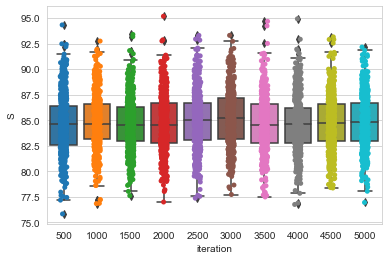

In [313]:
# S

#make a box plot by grouping together the first 500 obs, the second 500,...
data["iteration"] = (data['index'] // 500 + 1) * 500   # we divide the records in groups of 500
sns.set_style('whitegrid')   # setting the style
ax = sns.boxplot(x="iteration",y="S",data=data)   # representation of the box-plots
ax = sns.stripplot(x="iteration", y="S",data=data)   # representation of the observations

### Trace plots

#### Trace plot for $ \mu $

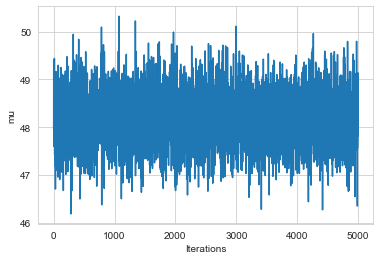

In [314]:
plt.plot(SMT[:, 1])
plt.xlabel("Iterations")
plt.ylabel("mu")
plt.show()

### Autocorrelation function and MC standard errors

#### Autocorrelation function and MC standard error for $ \tau^2 $

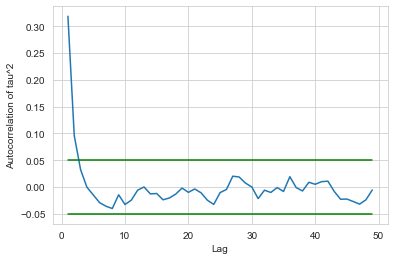


Lag-1 autocorrelations for the sequence tau^2:  0.3185630892637942

Effective sample size for tau^2:  3054
Approximate MC standard error for tau^2:  0.08054363767013292


In [315]:
samples = SMT[:,2]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of tau^2')
plt.show()

print()
print('Lag-1 autocorrelations for the sequence tau^2: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print('Effective sample size for tau^2: ', ess)
print('Approximate MC standard error for tau^2: ', mc_std_dev)

#### Autocorrelation function and MC standard error for $ \theta_{j} $

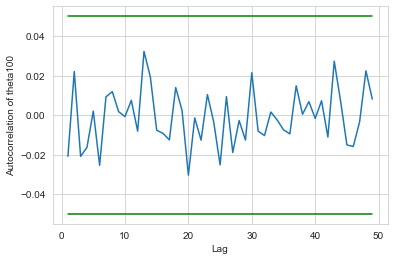


Lag-1 autocorrelations for the sequence theta100:  -0.020857124749934616

Effective sample size for theta100:  5217
Approximate MC standard error for theta100:  0.02216981019371519


In [316]:
j = 100   # change if you another parameter thetaj

samples = THETA[:,j-1]
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel(f'Autocorrelation of theta{j}')
plt.show()

print()
print(f'Lag-1 autocorrelations for the sequence theta{j}: ', autocorrs[0])

# computing the effective sample size (ess) and the approximate MC standard error (mc_std_dev)
print()
sample_mean = np.mean(samples)
sample_var = np.var(samples, ddof=1)
ess = int(len(samples) / (1 + 2 * autocorrs[0]))
mc_std_dev = np.sqrt(sample_var / ess)
print(f'Effective sample size for theta{j}: ', ess)
print(f'Approximate MC standard error for theta{j}: ', mc_std_dev)

## Estimation of the parameters

In [317]:
theta_est = np.mean(THETA, axis = 0)

print("Estimates of the theta:", theta_est)
print()
j = 15   # change with the index of the school you want the estimate of theta
print("Estimate of theta for the school: ", theta_est[j-1])
print()
print(f"The school with maximum theta is {np.argmax(theta_est)+1} and the corresponding value is {theta_est[np.argmax(theta_est)]}")
print(f"The school with minimum theta is {np.argmin(theta_est)+1} and the corresponding value is {theta_est[np.argmin(theta_est)]}")

Estimates of the theta: [50.55763434 46.69271161 48.7123084  47.45063    38.19375521 40.61650081
 41.77410547 48.76824899 48.99044237 42.1876655  55.68319673 50.27765024
 49.31396211 57.02629691 54.62756333 54.56013162 41.22364542 50.06244542
 44.48658632 46.20277213 50.23444154 47.96715548 51.27899973 45.94081183
 45.31695416 46.7829241  44.49441632 51.3346442  46.4609469  49.37718997
 49.05158652 50.0956069  47.44711587 45.99998658 54.57202951 52.3879855
 46.27622775 51.26374513 46.42119829 48.93538971 55.7463474  46.41055884
 50.77584941 49.13514727 45.67003094 41.27068198 44.5621773  46.98633239
 40.07323899 42.61177611 61.93089654 49.23624712 43.82053126 46.55611761
 43.73600847 49.06830142 44.4245418  48.44622479 49.50291149 42.73838008
 45.43690583 50.95349191 49.44327968 43.69722016 47.93555271 48.21117027
 57.40935767 45.26856933 51.39022591 43.97884107 46.84768219 39.30740021
 53.19011907 41.6405199  48.73924187 53.97492578 45.14796905 41.1094239
 58.94088479 51.14554024 47.1

In [318]:
print("Estimate of (sigma2, mu, tau2):", np.mean(SMT[:,0], axis = 0), np.mean(SMT[:,1], axis = 0), np.mean(SMT[:,2], axis = 0))
print()
print("Estimate of (sigma, mu, tau):", np.mean(np.sqrt(SMT[:,0]), axis = 0), np.mean(SMT[:,1], axis = 0), np.mean(np.sqrt(SMT[:,2]), axis = 0))

Estimate of (sigma2, mu, tau2): 84.79065198052201 48.17476835314022 25.724881098220706

Estimate of (sigma, mu, tau): 9.206992931994185 48.17476835314022 5.053463870191074
